# Caravana Data Preparation

In [69]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import datetime

from collections import defaultdict
from scipy.stats.stats import pearsonr

# CAMBIATE IL PATH PER FARLO FUNZIONARE NEL VOSTRO PC
df = pd.read_csv("./data/training_1st_corrections.csv")


def find_outliers(x, field, update=False):
    global candidates_outlier # necessario global perchè lavoro su raggruppamenti
    mode = x[field].mode()[0] if len(x[field].mode()) else np.NaN
    for index, row in x.iterrows():
        if row[field] != mode:
            candidates_outlier = candidates_outlier.append(row, ignore_index=True)
            if update:
                df.loc[df.RefId == row.RefId,field] = mode
    return candidates_outlier


def random_sampling(column, size):
    probabilities = column.value_counts(normalize=True)
    if len(probabilities):
        return pd.Series(np.random.choice(probabilities.index, size=size, p=probabilities.values))
    else:
        return pd.Series(([np.NaN]*size))

    
def _fillna_distribution_based(dataframe, column):
    rows_null = dataframe[dataframe[column].isnull()]
    l = len(rows_null)
    if l > 0:
        fillings = random_sampling(dataframe[column], l)
        df.loc[df.RefId.isin(rows_null.RefId), column] = fillings.values


def fillna_distribution(column):
    _fillna_distribution_based(df, column)


def fillna_group_distribution(groupby, column):
    for group_name, group in df.groupby(groupby):
        _fillna_distribution_based(group, column)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58386 entries, 0 to 58385
Data columns (total 33 columns):
RefId                                58386 non-null int64
IsBadBuy                             58386 non-null int64
PurchDate                            58386 non-null object
Auction                              58386 non-null object
VehicleAge                           58386 non-null int64
Make                                 58386 non-null object
Model                                58386 non-null object
Trim                                 56475 non-null object
SubModel                             58379 non-null object
Color                                58379 non-null object
Transmission                         58378 non-null object
WheelTypeID                          55813 non-null float64
WheelType                            55809 non-null object
VehOdo                               58386 non-null int64
Nationality                          58382 non-null object
Size     

Dopo aver valutato la qualità dei dati nel notebook precedente, ora possiamo effettuare alcune manipolazioni prima di passare all'analisi vera e propria.

## Eliminazione degli attributi non significativi

Quanto detto sopra vale anche per gli attributi __WheelType__ e __WheelTypeID__. Manentiamo solo il primo.

In [71]:
del df['WheelTypeID']

Gli attributi __VNZIP1__ e __VNST__ sono ridondanti e inoltre __VNZIP1__ ha troppi valori distinti riferiti ad uno stesso valore di __VNST__. In particolare il primo indica il codice postale e il secondo il paese di acquisot della macchina. Decidamo di mantenere __VNST__ per questioni di granularità.

In [72]:
del df['VNZIP1']

Gli attributi __KickDate__ e __AcquisitionType__ menzionati nel dizionario del dataset non sono effettivamente presenti nel dataset stesso.

## Correzione di missing values ed errori semantici

In [73]:
df.isnull().sum()

RefId                                   0
IsBadBuy                                0
PurchDate                               0
Auction                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                 1911
SubModel                                7
Color                                   7
Transmission                            8
WheelType                            2577
VehOdo                                  0
Nationality                             4
Size                                    4
TopThreeAmericanName                    4
MMRAcquisitionAuctionAveragePrice      13
MMRAcquisitionAuctionCleanPrice        13
MMRAcquisitionRetailAveragePrice       13
MMRAcquisitonRetailCleanPrice          13
MMRCurrentAuctionAveragePrice         245
MMRCurrentAuctionCleanPrice           245
MMRCurrentRetailAveragePrice          245
MMRCurrentRetailCleanPrice        

Correggiamo prima di tutto i 7 valori mancanti per l'attributo __SubModel__.

In [74]:
nullid = df[df['SubModel'].isnull()]['RefId']
fillna_group_distribution(['Make', 'ModelSimple'],'SubModel')
df[(df['RefId']).isin(nullid)]['SubModel']

23019       SEDAN LS 3.5L
28280      PASSENGER 3.9L
28961           SEDAN GT1
33225            SUV 4.6L
35224           COUPE R/T
48641       SEDAN SXT FFV
50661    CREW CAB 4.3L LS
Name: SubModel, dtype: object

Andiamo a correggere i missing values presenti in __Trim__. Per farlo utilizziamo la funzione fillna_distribution che prende in input un raggruppamento degli attributi da cui prendere la moda da sostituire ai missing value.

Anche senza un'approfondita conoscenza del dominio, ha senso ipotizzare che il livello di equipaggiamento di una macchina dipenda dal suo modello. Ricerche online confermano che ogni produttore ha la sua scala di Trim level che può variare anche da un modello all'altro della stessa casa produttrice.

In [75]:
notcorrected = df[df['Trim'].isnull()][['ModelSimple', 'SubModel', 'Trim']].copy(deep='True')

fillna_group_distribution(['ModelSimple', 'SubModel'], 'Trim')

In [76]:
df['Trim'].isnull().sum()

525

Per questi 525 record non è possibile inferire il livello di Trim usando __ModelSimple__ e __SubModel__. Siginifca che non esistono altre macchine con lo stesso modello e sotto modello che hanno un trim level non nullo.

A volte alcuni recordo hanno l'informazione sul trim level nel sotto modello, controlliamo

In [77]:
sub_with_trim_missing=df[df['Trim'].isnull()]['SubModel'].unique()

l = list()
for x in df['Trim'].unique():
    if x != np.NaN:
        if not isinstance(x, str):
            l.append(" "+str(x))
        else:
            l.append(" "+x)

sub_to_fix=[x for x in sub_with_trim_missing if x.endswith(tuple(l))]
sub_to_fix

['HARDTOP JLS', 'CARGO EXT 3.5L LT', 'REG CAB 4.0L XL', 'SEDAN S']

Possiamo fixare il trim missing per questi 4 SubModel.

In [78]:
df[(df['SubModel'].isin(sub_to_fix)) & df['Trim'].isnull()]
df.loc[df['RefId']==38392, 'Trim']='JLS'
df.loc[df['RefId']==31990, 'Trim']='LT'
df.loc[df['RefId']==12681, 'Trim']='XL'
df.loc[df['RefId']==22700, 'Trim']='S'
df.loc[df['RefId']==47467, 'Trim']='S'

Si potrebbe usare il pearson's chi squared per stimare la probabilità di trovare un determinato trim level in baseg ad ogni altro attributo categorico ma per ora cancelliamo semplicemente

In [79]:
df.dropna(inplace=True, subset=['Trim'])

Passiamo ora all'attributo __Nationality__.

In [80]:
df['Nationality'].value_counts()

AMERICAN          48420
OTHER ASIAN        6308
TOP LINE ASIAN     2988
OTHER               146
Name: Nationality, dtype: int64

I possibili valori per la nazionalità di una macchina possono essere i 4 di sopra. E' necessario verificare che __Other__ non sia un hidden missing value.

Per fare ciò abbiamo controllato nella fase di Data Understanding che non siano presenti macchine dello stesso produttore con nazionalità diversa. Questo controllo ci può far notare anche eventuali errori nel dataset.

Dal controllo è infatti emerso che è presente un errore nella nazionalità delle macchine del produttore __Toyota__

In [81]:
df[df['Make']=='TOYOTA']['Nationality'].value_counts()

TOP LINE ASIAN    894
OTHER ASIAN         4
Name: Nationality, dtype: int64

Dato che la nazionalità di un veicolo è riferita al produttore, veicoli dello stesso produttore non possono avere nazionalità diversa. Considerando la distribuzione del valore __Nationality__ per __Make__=Toyota, correggiamo i 4 recordo con "Other Asian"

In [82]:
df.loc[df['Make']=='TOYOTA', 'Nationality'] = 'TOP LINE ASIAN'

In realtà, per le macchine di nazionalità asiatica viene specificato se sono top line o no. Dato che questa è un informazione che non riguarda la nazionalità e può essere dedotta guardando al trim level correggiamo tutto in __ASIAN__

In [83]:
df.loc[df['Nationality'].isin(['TOP LINE ASIAN', 'OTHER ASIAN']), 'Nationality'] = 'ASIAN'

Con una veloce ricerca su google è possibile ottenere una migliore granularità per quanto riguarda la nazionalità dei veicoli per cui viene indicato solo __Other__

In [84]:
df[df['Nationality']=='OTHER']['Make'].value_counts()

df.loc[df['Make']=='VOLKSWAGEN', 'Nationality'] = 'GERMAN'
df.loc[df['Make']=='VOLVO', 'Nationality'] = 'SWEDISH'
df.loc[df['Make']=='MINI', 'Nationality'] = 'ENGLISH'

Otteniamo in questo modo una migliore granularità sull'attributo __Nationality__.

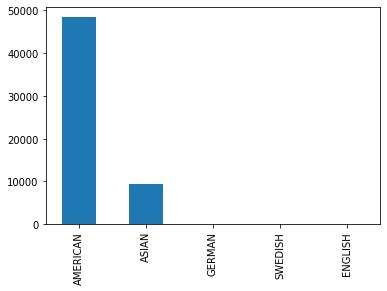

In [85]:
df['Nationality'].value_counts().plot(kind='bar')
plt.show()

In [86]:
df[df['Nationality'].isnull()]

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
15769,10897,0,10/19/2009,MANHEIM,7,GMC,SIERRA 1500,SL,BASE,WHITE,...,NaN,NaN,NaN,NC,7500.0,0,1455,SIERRA 1500,NaN,South
18532,25187,0,12/10/2009,OTHER,1,DODGE,NITRO 4WD V6,SXT,SUV 3.7L SE,WHITE,...,NaN,NaN,NaN,MS,9745.0,0,983,NITRO,4D,South
20016,69980,0,2/17/2010,ADESA,2,JEEP,PATRIOT 2WD 4C,SPO,SUV SPORT,SILVER,...,NaN,NaN,NaN,AZ,9655.0,0,825,PATRIOT,4D,West
35157,69990,0,2/24/2010,ADESA,2,JEEP,PATRIOT 2WD 4C,SPO,SUV SPORT,BLACK,...,11695.0,14026.0,15410.0,AZ,9955.0,0,825,PATRIOT,4D,West


Dato che l'attributo __Nationality__ è riferito all' attributo __Make__ ci troviamo davanti ad un missing value di tipo MAR. L'attributo __Nationality__ può essere corretto guardando il suo valore per i veicoli con lo stesso __Make__ dei missing.

In [87]:
df[(df['Make']=='DODGE') | (df['Make']=='JEEP') | (df['Make']=='GMC')].groupby('Make')['Nationality'].value_counts()

Make   Nationality
DODGE  AMERICAN       10354
GMC    AMERICAN         501
JEEP   AMERICAN        1285
Name: Nationality, dtype: int64

Considerando che il dato sulla nazionalità di altre macchine dello stesso produttore è uniforme (tutte le Dodge sono americane, così come tutte le Ford e tutte le GMC) possiamo correggere questi 4 missing values.

In [88]:
df.loc[df['Nationality'].isnull(), 'Nationality']='AMERICAN'

Il prossimo attributo che consideriamo è __TopThreeAmericanName__. I record con il missing value sono gli stessi 4 che avevano __Nationality__ come mancante. Per questa correzione vale il discorso fatto per l'attributo precedente.

In [89]:
df[df['TopThreeAmericanName'].isnull()]

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
15769,10897,0,10/19/2009,MANHEIM,7,GMC,SIERRA 1500,SL,BASE,WHITE,...,NaN,NaN,NaN,NC,7500.0,0,1455,SIERRA 1500,NaN,South
18532,25187,0,12/10/2009,OTHER,1,DODGE,NITRO 4WD V6,SXT,SUV 3.7L SE,WHITE,...,NaN,NaN,NaN,MS,9745.0,0,983,NITRO,4D,South
20016,69980,0,2/17/2010,ADESA,2,JEEP,PATRIOT 2WD 4C,SPO,SUV SPORT,SILVER,...,NaN,NaN,NaN,AZ,9655.0,0,825,PATRIOT,4D,West
35157,69990,0,2/24/2010,ADESA,2,JEEP,PATRIOT 2WD 4C,SPO,SUV SPORT,BLACK,...,11695.0,14026.0,15410.0,AZ,9955.0,0,825,PATRIOT,4D,West


In [90]:
df[(df['Make']=='DODGE') | (df['Make']=='JEEP') | (df['Make']=='GMC')].groupby('Make')['TopThreeAmericanName'].value_counts()

Make   TopThreeAmericanName
DODGE  CHRYSLER                10354
GMC    GM                        501
JEEP   CHRYSLER                 1285
Name: TopThreeAmericanName, dtype: int64

In [91]:
df.loc[(df['TopThreeAmericanName'].isnull()) & (df['Make']=='DODGE'), 'TopThreeAmericanName']='CHRYSLER'
df.loc[(df['TopThreeAmericanName'].isnull()) & (df['Make']=='GMC'), 'TopThreeAmericanName']='GM'
df.loc[(df['TopThreeAmericanName'].isnull()) & (df['Make']=='JEEP'), 'TopThreeAmericanName']='CHRYSLER'

Ancora una volta, i 4 record con missing values per l'attributo __Size__ sono gli stessi dei due attributi sopra

In [92]:
df[df['Size'].isnull()]

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
15769,10897,0,10/19/2009,MANHEIM,7,GMC,SIERRA 1500,SL,BASE,WHITE,...,NaN,NaN,NaN,NC,7500.0,0,1455,SIERRA 1500,NaN,South
18532,25187,0,12/10/2009,OTHER,1,DODGE,NITRO 4WD V6,SXT,SUV 3.7L SE,WHITE,...,NaN,NaN,NaN,MS,9745.0,0,983,NITRO,4D,South
20016,69980,0,2/17/2010,ADESA,2,JEEP,PATRIOT 2WD 4C,SPO,SUV SPORT,SILVER,...,NaN,NaN,NaN,AZ,9655.0,0,825,PATRIOT,4D,West
35157,69990,0,2/24/2010,ADESA,2,JEEP,PATRIOT 2WD 4C,SPO,SUV SPORT,BLACK,...,11695.0,14026.0,15410.0,AZ,9955.0,0,825,PATRIOT,4D,West


Assegnamo un valore a __Size__ in base alla moda di altri veicoli con lo stesso __Model__.

In [93]:
fillna_group_distribution(['ModelSimple'],'Size')

In [94]:
df[df['Size'].isnull()]

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
15769,10897,0,10/19/2009,MANHEIM,7,GMC,SIERRA 1500,SL,BASE,WHITE,...,NaN,NaN,NaN,NC,7500.0,0,1455,SIERRA 1500,NaN,South


Non esiste nessuna altra __SIERRA 1500__ nel dataset. Prendiamo in considerazione l'ipotesi di eliminare questo record, che tra l'altro presenta altri valori mancanti su diversi attributi.

In [95]:
df=df.drop([15769])
df['Size'].isnull().sum()

0

Passiamo ora all'attributo __Transmission__.

In [96]:
df[df['Transmission'].isnull()]

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
23019,70466,0,1/15/2009,ADESA,5,CHEVROLET,IMPALA 3.4L V6 SFI,BAS,SEDAN LS 3.5L,NaN,...,5219.0,4845.0,6137.0,TX,4470.0,0,2152,IMPALA,NaN,South
28280,70482,0,1/15/2009,ADESA,3,FORD,FREESTAR FWD V6 3.9L,SE,PASSENGER 3.9L,NaN,...,7186.0,6710.0,8261.0,TX,4970.0,0,1633,FREESTAR,NaN,South
28961,70469,0,1/15/2009,ADESA,5,PONTIAC,GRAND AM V6 3.4L V6,SE,SEDAN GT1,NaN,...,5001.0,4615.0,5901.0,TX,4170.0,0,2412,GRAND AM,NaN,South
35224,24596,0,6/24/2009,MANHEIM,3,DODGE,STRATUS V6 2.7L V6 M,SXT,COUPE R/T,NaN,...,6535.0,6565.0,7558.0,FL,6200.0,0,1215,STRATUS,NaN,South
40504,15917,0,10/13/2009,MANHEIM,4,MERCURY,MONTEGO 3.0L V6 EFI,BAS,SEDAN LUXURY,RED,...,7948.0,10946.0,11577.0,TX,7695.0,0,1506,MONTEGO,4D,South
48641,24585,0,6/24/2009,MANHEIM,3,DODGE,STRATUS V6 2.7L V6 M,SXT,SEDAN SXT FFV,NaN,...,6461.0,6418.0,7478.0,FL,6200.0,0,975,STRATUS,NaN,South
50661,70464,0,1/15/2009,ADESA,8,CHEVROLET,S10 PICKUP 2WD 4C 2.,BAS,CREW CAB 4.3L LS,NaN,...,3800.0,3587.0,4604.0,TX,4770.0,0,2322,S10 PICKUP,NaN,South


Per quanto riguarda gli attributi __WheelType__ e __WheelTypeID__ dato che sono ridondanti dobbiamo sceglierne uno ed eventualmente correggere valori mancanti o errati.

Abbiamo scelto il primo. 

In [97]:
df['WheelType'].isnull().sum()

2547

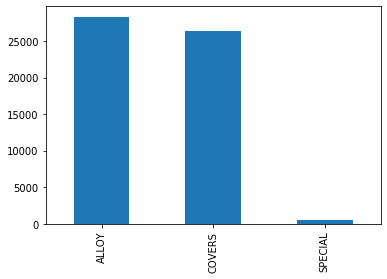

ALLOY      28307
COVERS     26424
SPECIAL      587
Name: WheelType, dtype: int64

In [98]:
wtnull = df['WheelType'].copy(deep=True)
wtnull.value_counts().plot(kind='bar')
plt.show()
wtnull.value_counts()

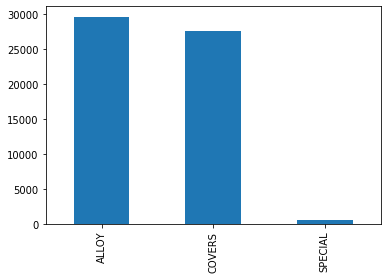

ALLOY      29632
COVERS     27613
SPECIAL      619
Name: WheelType, dtype: int64

In [99]:
fillna_group_distribution(['Trim'], 'WheelType')
df['WheelType'].value_counts().plot(kind='bar')
plt.show()
df['WheelType'].value_counts()

In [100]:
df[df.WheelType.isnull()]

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
7243,60408,1,12/3/2010,ADESA,9,SUZUKI,GRAND VITARA 4WD,JLX,SPORT UTILITY JLX,WHITE,...,3119.0,4851.0,5750.0,TN,3390.0,0,1785,GRAND VITARA,4D,South


In [101]:
df[df['Model']=='GRAND VITARA 4WD'][['Model','WheelType','VehicleAge','SubModel','Trim']]

,Model,WheelType,VehicleAge,SubModel,Trim
6675,GRAND VITARA 4WD,ALLOY,6,SPORT UTILITY JS,LX
7243,GRAND VITARA 4WD,NaN,9,SPORT UTILITY JLX,JLX
20589,GRAND VITARA 4WD,ALLOY,5,SPORT UTILITY JS,LX
35467,GRAND VITARA 4WD,ALLOY,6,SPORT UTILITY JS,LX


Secondo cars.com alla pagina https://www.cars.com/research/suzuki-grand_vitara-2001/specs/usb10szs062a0/ questa macchina con questo trim level ha i cerchioni covers di default e alloy come optional.

Per il momento assumiamo che sia ALLOY, per stare in linea con i valori delle altre con lo stesso modello.

In [102]:
df.loc[df['Model']=='GRAND VITARA 4WD', 'WheelType']='ALLOY'

Dai grafici qualche cella sopra, vedimao che la distribuzione di valori è rispettata da queste sostituzioni, le prendiamo per buone.

Per l'attributo __Color__ useremo semplicemente la distribuzione di probabilità per sostituire i valori mancanti.

In [103]:
df[df['Color'].isnull()]

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
23019,70466,0,1/15/2009,ADESA,5,CHEVROLET,IMPALA 3.4L V6 SFI,BAS,SEDAN LS 3.5L,NaN,...,5219.0,4845.0,6137.0,TX,4470.0,0,2152,IMPALA,NaN,South
28280,70482,0,1/15/2009,ADESA,3,FORD,FREESTAR FWD V6 3.9L,SE,PASSENGER 3.9L,NaN,...,7186.0,6710.0,8261.0,TX,4970.0,0,1633,FREESTAR,NaN,South
28961,70469,0,1/15/2009,ADESA,5,PONTIAC,GRAND AM V6 3.4L V6,SE,SEDAN GT1,NaN,...,5001.0,4615.0,5901.0,TX,4170.0,0,2412,GRAND AM,NaN,South
35224,24596,0,6/24/2009,MANHEIM,3,DODGE,STRATUS V6 2.7L V6 M,SXT,COUPE R/T,NaN,...,6535.0,6565.0,7558.0,FL,6200.0,0,1215,STRATUS,NaN,South
48641,24585,0,6/24/2009,MANHEIM,3,DODGE,STRATUS V6 2.7L V6 M,SXT,SEDAN SXT FFV,NaN,...,6461.0,6418.0,7478.0,FL,6200.0,0,975,STRATUS,NaN,South
50661,70464,0,1/15/2009,ADESA,8,CHEVROLET,S10 PICKUP 2WD 4C 2.,BAS,CREW CAB 4.3L LS,NaN,...,3800.0,3587.0,4604.0,TX,4770.0,0,2322,S10 PICKUP,NaN,South


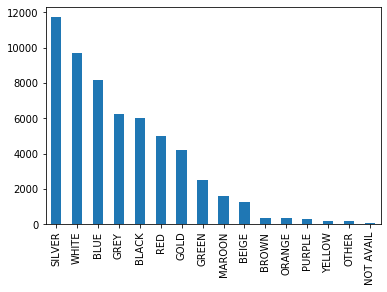

In [104]:
df['Color'].value_counts().plot(kind='bar')
plt.show()

In [105]:
fillna_distribution('Color')

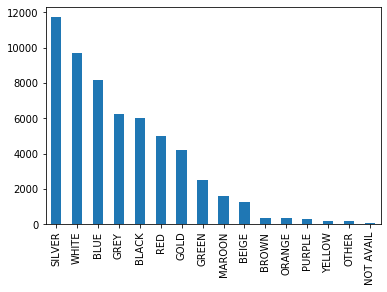

In [106]:
df['Color'].value_counts().plot(kind='bar')
plt.show()

In [107]:
df['Color'].isnull().sum()

0

Anche questa sostituzione rispetta la distribuzione dei valori originale.

Il tipo di trasmissione, verosimilmente, dipende da modello e trim level della macchina.

In [108]:
df[df['Transmission'].isnull()]

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
23019,70466,0,1/15/2009,ADESA,5,CHEVROLET,IMPALA 3.4L V6 SFI,BAS,SEDAN LS 3.5L,WHITE,...,5219.0,4845.0,6137.0,TX,4470.0,0,2152,IMPALA,NaN,South
28280,70482,0,1/15/2009,ADESA,3,FORD,FREESTAR FWD V6 3.9L,SE,PASSENGER 3.9L,BLACK,...,7186.0,6710.0,8261.0,TX,4970.0,0,1633,FREESTAR,NaN,South
28961,70469,0,1/15/2009,ADESA,5,PONTIAC,GRAND AM V6 3.4L V6,SE,SEDAN GT1,GOLD,...,5001.0,4615.0,5901.0,TX,4170.0,0,2412,GRAND AM,NaN,South
35224,24596,0,6/24/2009,MANHEIM,3,DODGE,STRATUS V6 2.7L V6 M,SXT,COUPE R/T,BLUE,...,6535.0,6565.0,7558.0,FL,6200.0,0,1215,STRATUS,NaN,South
40504,15917,0,10/13/2009,MANHEIM,4,MERCURY,MONTEGO 3.0L V6 EFI,BAS,SEDAN LUXURY,RED,...,7948.0,10946.0,11577.0,TX,7695.0,0,1506,MONTEGO,4D,South
48641,24585,0,6/24/2009,MANHEIM,3,DODGE,STRATUS V6 2.7L V6 M,SXT,SEDAN SXT FFV,GOLD,...,6461.0,6418.0,7478.0,FL,6200.0,0,975,STRATUS,NaN,South
50661,70464,0,1/15/2009,ADESA,8,CHEVROLET,S10 PICKUP 2WD 4C 2.,BAS,CREW CAB 4.3L LS,BLUE,...,3800.0,3587.0,4604.0,TX,4770.0,0,2322,S10 PICKUP,NaN,South


In [109]:
fillna_group_distribution(['Trim','SubModel'], 'Transmission')

7 valori corretti in questo modo sicuramente non alterano la distribuzione dei valori dell'attributo __Transmission__.

In [110]:
df.isnull().sum()

RefId                                   0
IsBadBuy                                0
PurchDate                               0
Auction                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                    0
SubModel                                0
Color                                   0
Transmission                            5
WheelType                               0
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice      13
MMRAcquisitionAuctionCleanPrice        13
MMRAcquisitionRetailAveragePrice       13
MMRAcquisitonRetailCleanPrice          13
MMRCurrentAuctionAveragePrice         244
MMRCurrentAuctionCleanPrice           244
MMRCurrentRetailAveragePrice          244
MMRCurrentRetailCleanPrice        

In [111]:
df[df['Transmission'].isnull()]

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
23019,70466,0,1/15/2009,ADESA,5,CHEVROLET,IMPALA 3.4L V6 SFI,BAS,SEDAN LS 3.5L,WHITE,...,5219.0,4845.0,6137.0,TX,4470.0,0,2152,IMPALA,NaN,South
28280,70482,0,1/15/2009,ADESA,3,FORD,FREESTAR FWD V6 3.9L,SE,PASSENGER 3.9L,BLACK,...,7186.0,6710.0,8261.0,TX,4970.0,0,1633,FREESTAR,NaN,South
28961,70469,0,1/15/2009,ADESA,5,PONTIAC,GRAND AM V6 3.4L V6,SE,SEDAN GT1,GOLD,...,5001.0,4615.0,5901.0,TX,4170.0,0,2412,GRAND AM,NaN,South
35224,24596,0,6/24/2009,MANHEIM,3,DODGE,STRATUS V6 2.7L V6 M,SXT,COUPE R/T,BLUE,...,6535.0,6565.0,7558.0,FL,6200.0,0,1215,STRATUS,NaN,South
50661,70464,0,1/15/2009,ADESA,8,CHEVROLET,S10 PICKUP 2WD 4C 2.,BAS,CREW CAB 4.3L LS,BLUE,...,3800.0,3587.0,4604.0,TX,4770.0,0,2322,S10 PICKUP,NaN,South


## Correzione dei missing values sugli attributi del prezzo

Passiamo ora agli attributi _di prezzo_.

La fase di data understanding ha evidenziato che questi attributi oltre che avere i classici missing values presentano anche dei valori anomali: 0 e 1.

In [112]:
df[['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 
    'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
    'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost']].isin([0,1]).sum()

MMRAcquisitionAuctionAveragePrice    644
MMRAcquisitionAuctionCleanPrice      644
MMRAcquisitionRetailAveragePrice     644
MMRAcquisitonRetailCleanPrice        644
MMRCurrentAuctionAveragePrice        391
MMRCurrentAuctionCleanPrice          391
MMRCurrentRetailAveragePrice         391
MMRCurrentRetailCleanPrice           391
VehBCost                               1
dtype: int64

In [113]:
df.loc[df['MMRAcquisitionAuctionAveragePrice']<=1,'MMRAcquisitionAuctionAveragePrice']=np.NaN
df.loc[df['MMRAcquisitionAuctionCleanPrice']<=1,'MMRAcquisitionAuctionCleanPrice']=np.NaN
df.loc[df['MMRAcquisitionRetailAveragePrice']<=1,'MMRAcquisitionRetailAveragePrice']=np.NaN
df.loc[df['MMRAcquisitonRetailCleanPrice']<=1,'MMRAcquisitonRetailCleanPrice']=np.NaN
df.loc[df['MMRCurrentAuctionAveragePrice']<=1,'MMRCurrentAuctionAveragePrice']=np.NaN
df.loc[df['MMRCurrentAuctionCleanPrice']<=1,'MMRCurrentAuctionCleanPrice']=np.NaN
df.loc[df['MMRCurrentRetailAveragePrice']<=1,'MMRCurrentRetailAveragePrice']=np.NaN
df.loc[df['MMRCurrentRetailCleanPrice']<=1,'MMRCurrentRetailCleanPrice']=np.NaN

In [114]:
df[['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 
    'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
    'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost']].isnull().sum()

MMRAcquisitionAuctionAveragePrice    657
MMRAcquisitionAuctionCleanPrice      657
MMRAcquisitionRetailAveragePrice     657
MMRAcquisitonRetailCleanPrice        657
MMRCurrentAuctionAveragePrice        635
MMRCurrentAuctionCleanPrice          635
MMRCurrentRetailAveragePrice         635
MMRCurrentRetailCleanPrice           635
VehBCost                               0
dtype: int64

In [115]:
df_copy = df.copy(deep=True) # salvo per la regressione

In [116]:
prices = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 
          'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 
          'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 
          'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']

stats_with_missing = df[prices].describe()

for attr in prices:
    df[attr] = df.groupby("ModelSimple")[attr].transform(lambda x: x.fillna(x.mean()))
    
stats_wout_missing = df[prices].describe()

In [117]:
stats_with_missing

,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice
count,57208.000000,57208.000000,57208.000000,57208.000000,57230.000000,57230.000000,57230.000000,57230.000000
mean,6189.401185,7446.953293,8585.069081,9953.504335,6165.924428,7431.539752,8828.419483,10205.639053
std,2373.573222,2606.661955,3029.534747,3223.838988,2379.114661,2612.967638,3004.094373,3200.720476
min,884.000000,1076.000000,1455.000000,1662.000000,369.000000,494.000000,899.000000,1034.000000
25%,4327.000000,5467.000000,6358.000000,7550.000000,4303.000000,5447.000000,6576.000000,7829.250000
50%,6124.000000,7340.000000,8481.000000,9837.000000,6074.000000,7324.000000,8756.000000,10118.000000
75%,7786.000000,9042.000000,10677.000000,12111.000000,7749.000000,9025.000000,10922.000000,12321.000000
max,35722.000000,36859.000000,39080.000000,40308.000000,35722.000000,36859.000000,39080.000000,40308.000000


In [118]:
stats_wout_missing

,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice
count,57863.000000,57863.000000,57863.000000,57863.000000,57864.000000,57864.000000,57864.000000,57864.000000
mean,6192.271805,7450.876067,8589.023204,9958.485366,6165.931935,7432.461467,8829.121182,10207.198019
std,2366.392359,2599.232726,3018.799073,3212.966635,2372.166893,2605.711988,2994.515991,3190.954997
min,884.000000,1076.000000,1455.000000,1662.000000,369.000000,494.000000,899.000000,1034.000000
25%,4342.000000,5485.000000,6368.500000,7571.000000,4311.000000,5462.000000,6587.000000,7840.750000
50%,6129.000000,7353.000000,8488.000000,9849.000000,6078.000000,7330.442122,8756.000000,10127.000000
75%,7782.000000,9044.000000,10665.500000,12106.500000,7746.000000,9025.000000,10918.000000,12316.000000
max,35722.000000,36859.000000,39080.000000,40308.000000,35722.000000,36859.000000,39080.000000,40308.000000


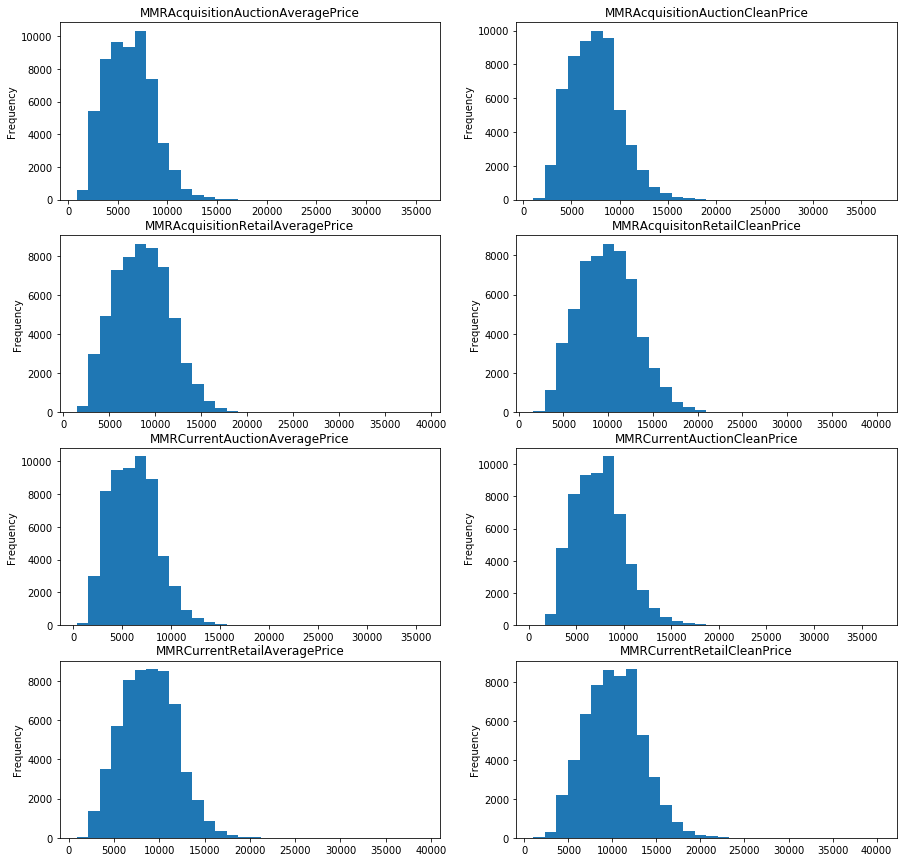

In [119]:
"""
Considerazione su questi grafici: potete notare con df['NOME_ATTR'].value_counts() che ci sono molti valori a 0 
per ognuno degli attributi qua sotto, pensavo che forse sarebbero da considerarsi nulli e quindi eliminarli oppure 
sostituirli con la media calcolata escludendoli.
"""

# Set up a grid of plots
fig = plt.figure(figsize=(15, 15)) 
fig_dims = (4, 2)

# Acquisition price for this vehicle in average condition at time of purchase
plt.subplot2grid(fig_dims, (0, 0))
df['MMRAcquisitionAuctionAveragePrice'].plot(bins=30, kind='hist', title='MMRAcquisitionAuctionAveragePrice')

# Acquisition price for this vehicle in the above Average condition at time of purchase
plt.subplot2grid(fig_dims, (0, 1))
df['MMRAcquisitionAuctionCleanPrice'].plot(kind='hist', bins=30, title='MMRAcquisitionAuctionCleanPrice')

# Acquisition price for this vehicle in the retail market in average condition at time of purchase
plt.subplot2grid(fig_dims, (1, 0))
df['MMRAcquisitionRetailAveragePrice'].plot(kind='hist', bins=30, 
                                                           title='MMRAcquisitionRetailAveragePrice')
plt.xticks(rotation=0)

# Acquisition price for this vehicle in the retail market in above average condition at time of purchase
plt.subplot2grid(fig_dims, (1, 1))
df['MMRAcquisitonRetailCleanPrice'].plot(kind='hist', bins=30, 
                                                        title='MMRAcquisitonRetailCleanPrice')

# Acquisition price for this vehicle in average condition as of current day
plt.subplot2grid(fig_dims, (2, 0))
df['MMRCurrentAuctionAveragePrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentAuctionAveragePrice')

# Acquisition price for this vehicle in the above condition as of current day
plt.subplot2grid(fig_dims, (2, 1))
df['MMRCurrentAuctionCleanPrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentAuctionCleanPrice')

# Acquisition price for this vehicle in the retail market in average condition as of current day
plt.subplot2grid(fig_dims, (3, 0))
df['MMRCurrentRetailAveragePrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentRetailAveragePrice')

# Acquisition price for this vehicle in the retail market in above average condition as of current day
plt.subplot2grid(fig_dims, (3, 1))
df['MMRCurrentRetailCleanPrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentRetailCleanPrice')

plt.savefig('./plots/MMRs_mean_filled.png')
plt.show()

Decidiamo di eliminare i restanti missing values.

In [120]:
df.dropna(inplace=True, subset=prices)

In [121]:
df.isnull().sum()

RefId                                   0
IsBadBuy                                0
PurchDate                               0
Auction                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                    0
SubModel                                0
Color                                   0
Transmission                            5
WheelType                               0
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice       0
MMRAcquisitionAuctionCleanPrice         0
MMRAcquisitionRetailAveragePrice        0
MMRAcquisitonRetailCleanPrice           0
MMRCurrentAuctionAveragePrice           0
MMRCurrentAuctionCleanPrice             0
MMRCurrentRetailAveragePrice            0
MMRCurrentRetailCleanPrice        

In [122]:
df.Doors.value_counts()

4D    47386
2D     2642
Name: Doors, dtype: int64

In [125]:
fillna_group_distribution('SubModel', 'Doors')
fillna_group_distribution('ModelSimple', 'Doors')
fillna_group_distribution('Trim', 'Doors')

In [126]:
df.isnull().sum()

RefId                                  0
IsBadBuy                               0
PurchDate                              0
Auction                                0
VehicleAge                             0
Make                                   0
Model                                  0
Trim                                   0
SubModel                               0
Color                                  0
Transmission                           5
WheelType                              0
VehOdo                                 0
Nationality                            0
Size                                   0
TopThreeAmericanName                   0
MMRAcquisitionAuctionAveragePrice      0
MMRAcquisitionAuctionCleanPrice        0
MMRAcquisitionRetailAveragePrice       0
MMRAcquisitonRetailCleanPrice          0
MMRCurrentAuctionAveragePrice          0
MMRCurrentAuctionCleanPrice            0
MMRCurrentRetailAveragePrice           0
MMRCurrentRetailCleanPrice             0
VNST            

In [127]:
df.dropna(inplace=True)

In [128]:
df.to_csv(index=False, path_or_buf='./data/training_ready_no_regression.csv')

###### Multivariate Linear Regressor

In [55]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [56]:
df_copy.isnull().sum()

RefId                                   0
IsBadBuy                                0
PurchDate                               0
Auction                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                    0
SubModel                                0
Color                                   0
Transmission                            0
WheelType                               0
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice     657
MMRAcquisitionAuctionCleanPrice       657
MMRAcquisitionRetailAveragePrice      657
MMRAcquisitonRetailCleanPrice         657
MMRCurrentAuctionAveragePrice         635
MMRCurrentAuctionCleanPrice           635
MMRCurrentRetailAveragePrice          635
MMRCurrentRetailCleanPrice        

In [57]:
df_full = df_copy.copy().dropna()
df_full.isnull().sum()

RefId                                0
IsBadBuy                             0
PurchDate                            0
Auction                              0
VehicleAge                           0
Make                                 0
Model                                0
Trim                                 0
SubModel                             0
Color                                0
Transmission                         0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
VNST                                 0
VehBCost                 

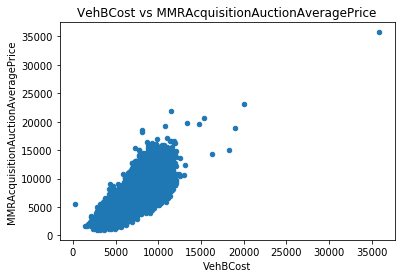

In [58]:
att = 'MMRAcquisitionAuctionAveragePrice'
df_full.plot.scatter(x='VehBCost', y=att, style='o')
plt.title('VehBCost vs '+att)  
plt.xlabel('VehBCost')  
plt.ylabel(att)  
plt.show()

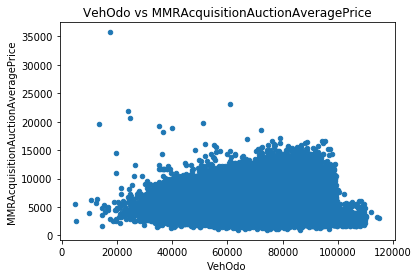

In [59]:
df_full.plot.scatter(x='VehOdo', y=att, style='o')
plt.title('VehOdo vs '+att)  
plt.xlabel('VehOdo')  
plt.ylabel(att)  
plt.show()

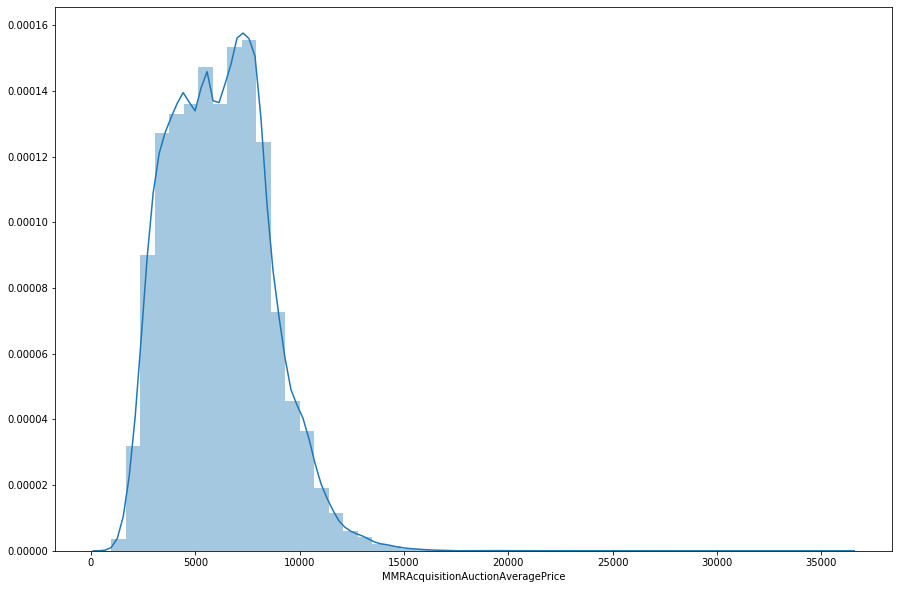

In [60]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df_full[att])

In [61]:
useful = ['VehicleAge','VehOdo', 'VehBCost', 'WarrantyCost']
X = df_full[useful].values
y = df_full[att].values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [63]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
#coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
#coeff_df

In [65]:
y_pred = regressor.predict(X_test)

In [66]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1

,Actual,Predicted
0,5807.0,5549.708184
1,2391.0,3244.474188
2,4798.0,4793.604327
3,7270.0,7108.148793
4,9555.0,9319.175226
5,5632.0,6049.932027
6,5727.0,6592.676537
7,6769.0,5660.162631
8,7975.0,7766.877182
9,16472.0,10407.654510


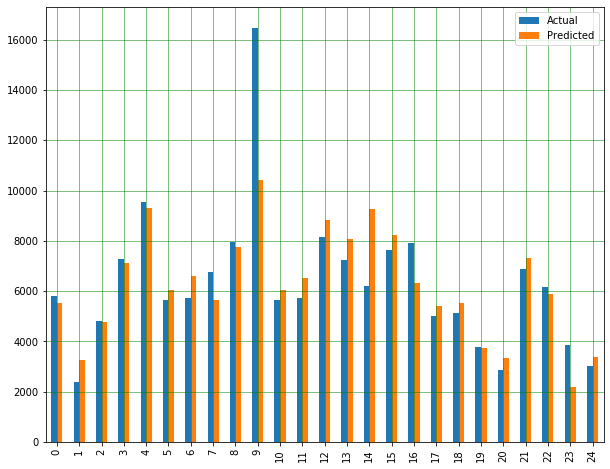

In [67]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [68]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 707.1518183433064
Mean Squared Error: 885891.0542328317
Root Mean Squared Error: 941.2178569453682


In [69]:
tofill = df_copy[df_copy[att].isnull()]
tofill = tofill[useful]
new = regressor.predict(tofill)
df_copy.loc[df_copy[att].isnull(), att] = new

In [70]:
df_copy.isnull().sum()

RefId                                   0
IsBadBuy                                0
PurchDate                               0
Auction                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                    0
SubModel                                0
Color                                   0
Transmission                            0
WheelType                               0
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice       0
MMRAcquisitionAuctionCleanPrice       657
MMRAcquisitionRetailAveragePrice      657
MMRAcquisitonRetailCleanPrice         657
MMRCurrentAuctionAveragePrice         635
MMRCurrentAuctionCleanPrice           635
MMRCurrentRetailAveragePrice          635
MMRCurrentRetailCleanPrice        

In [71]:
import numpy as np
from sklearn.linear_model import LinearRegression

to_estimate = ['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
useful = ['VehicleAge', 'VehOdo', 'VehBCost', 'WarrantyCost', att]

for att in to_estimate:
    nonull = df_copy.copy(deep=False).dropna()
    
    #for elim in useful:
    #    nonull = nonull.drop(nonull[nonull[elim].isnull()].index) #elimino le righe dove qualche attributo utile è null
    #nonull = nonull.drop(nonull[nonull[att].isnull()].index) #elimino le righe dove l'attributo che voglio calcolare non c'è
    
    X = nonull[useful].values
    y = nonull[att].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)
    
    y_pred = regressor.predict(X_test)
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    tofill = df_copy[df_copy[att].isnull()]
    tofill = tofill[useful]
    new = regressor.predict(tofill)
    
    df_copy.loc[df_copy[att].isnull(), att] = new #aggiorno i missing values con quelli che ho trovato
    useful.append(att) #aggiungo l'attributo corretto alla lista degli attributi per la regressione lineare

Mean Absolute Error: 243.39692295460299
Mean Squared Error: 102890.28734561606
Root Mean Squared Error: 320.76515918287646
Mean Absolute Error: 1150.2582212056382
Mean Squared Error: 1530078.2607274991
Root Mean Squared Error: 1236.963322304869
Mean Absolute Error: 151.66603900808985
Mean Squared Error: 73174.23927262238
Root Mean Squared Error: 270.50737378604373
Mean Absolute Error: 431.17912413641034
Mean Squared Error: 443912.12676915753
Root Mean Squared Error: 666.2673087951694
Mean Absolute Error: 163.55042730594087
Mean Squared Error: 52623.571358679634
Root Mean Squared Error: 229.3982810717631
Mean Absolute Error: 584.4423789119111
Mean Squared Error: 615068.0412203565
Root Mean Squared Error: 784.2627373657099
Mean Absolute Error: 169.61720781202186
Mean Squared Error: 76452.29459366701
Root Mean Squared Error: 276.5000806395308


In [72]:
df_copy.isnull().sum()

RefId                                   0
IsBadBuy                                0
PurchDate                               0
Auction                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                    0
SubModel                                0
Color                                   0
Transmission                            0
WheelType                               0
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice       0
MMRAcquisitionAuctionCleanPrice         0
MMRAcquisitionRetailAveragePrice        0
MMRAcquisitonRetailCleanPrice           0
MMRCurrentAuctionAveragePrice           0
MMRCurrentAuctionCleanPrice             0
MMRCurrentRetailAveragePrice            0
MMRCurrentRetailCleanPrice        

##### Checking delle distribuzioni

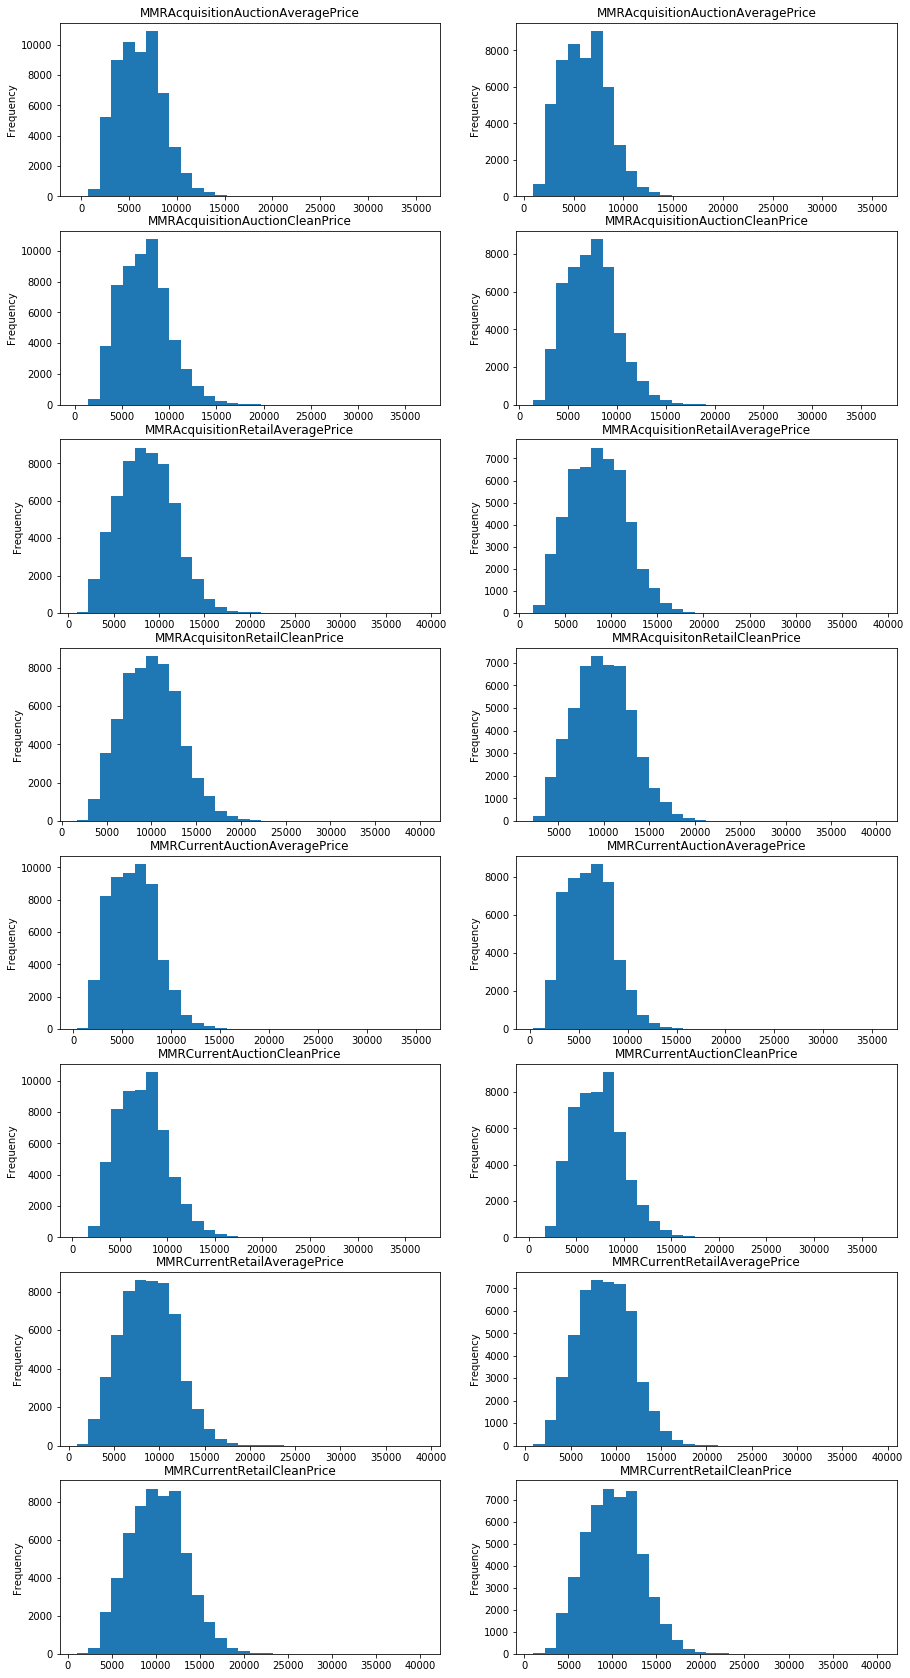

In [73]:
"""
Considerazione su questi grafici: potete notare con df['NOME_ATTR'].value_counts() che ci sono molti valori a 0 
per ognuno degli attributi qua sotto, pensavo che forse sarebbero da considerarsi nulli e quindi eliminarli oppure 
sostituirli con la media calcolata escludendoli.
"""

# Set up a grid of plots
fig = plt.figure(figsize=(15, 30)) 
fig_dims = (8, 2)

# Acquisition price for this vehicle in average condition at time of purchase
plt.subplot2grid(fig_dims, (0, 0))
df_copy['MMRAcquisitionAuctionAveragePrice'].plot(bins=30, kind='hist', title='MMRAcquisitionAuctionAveragePrice')
plt.subplot2grid(fig_dims, (0, 1))
df_full['MMRAcquisitionAuctionAveragePrice'].plot(bins=30, kind='hist', title='MMRAcquisitionAuctionAveragePrice')

# Acquisition price for this vehicle in the above Average condition at time of purchase
plt.subplot2grid(fig_dims, (1, 0))
df_copy['MMRAcquisitionAuctionCleanPrice'].plot(kind='hist', bins=30, title='MMRAcquisitionAuctionCleanPrice')
plt.subplot2grid(fig_dims, (1, 1))
df_full['MMRAcquisitionAuctionCleanPrice'].plot(kind='hist', bins=30, title='MMRAcquisitionAuctionCleanPrice')

# Acquisition price for this vehicle in the retail market in average condition at time of purchase
plt.subplot2grid(fig_dims, (2, 0))
df_copy['MMRAcquisitionRetailAveragePrice'].plot(kind='hist', bins=30, 
                                                           title='MMRAcquisitionRetailAveragePrice')
plt.xticks(rotation=0)
plt.subplot2grid(fig_dims, (2, 1))
df_full['MMRAcquisitionRetailAveragePrice'].plot(kind='hist', bins=30, 
                                                           title='MMRAcquisitionRetailAveragePrice')
plt.xticks(rotation=0)

# Acquisition price for this vehicle in the retail market in above average condition at time of purchase
plt.subplot2grid(fig_dims, (3, 0))
df_copy['MMRAcquisitonRetailCleanPrice'].plot(kind='hist', bins=30, 
                                                        title='MMRAcquisitonRetailCleanPrice')
plt.subplot2grid(fig_dims, (3, 1))
df_full['MMRAcquisitonRetailCleanPrice'].plot(kind='hist', bins=30, 
                                                        title='MMRAcquisitonRetailCleanPrice')

# Acquisition price for this vehicle in average condition as of current day
plt.subplot2grid(fig_dims, (4, 0))
df_copy['MMRCurrentAuctionAveragePrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentAuctionAveragePrice')
plt.subplot2grid(fig_dims, (4, 1))
df_full['MMRCurrentAuctionAveragePrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentAuctionAveragePrice')

# Acquisition price for this vehicle in the above condition as of current day
plt.subplot2grid(fig_dims, (5, 0))
df_copy['MMRCurrentAuctionCleanPrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentAuctionCleanPrice')
plt.subplot2grid(fig_dims, (5, 1))
df_full['MMRCurrentAuctionCleanPrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentAuctionCleanPrice')

# Acquisition price for this vehicle in the retail market in average condition as of current day
plt.subplot2grid(fig_dims, (6, 0))
df_copy['MMRCurrentRetailAveragePrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentRetailAveragePrice')
plt.subplot2grid(fig_dims, (6, 1))
df_full['MMRCurrentRetailAveragePrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentRetailAveragePrice')

# Acquisition price for this vehicle in the retail market in above average condition as of current day
plt.subplot2grid(fig_dims, (7, 0))
df_copy['MMRCurrentRetailCleanPrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentRetailCleanPrice')
plt.subplot2grid(fig_dims, (7, 1))
df_full['MMRCurrentRetailCleanPrice'].plot(kind='hist', bins=30, 
                                                        title='MMRCurrentRetailCleanPrice')


plt.show()

In [74]:
df_copy.to_csv(index=False, path_or_buf='./data/training_ready_regression.csv')

Sono stati trovati 7 missing value per color. Sono stati trasformati con la moda relativa al modello di riferimento del veicolo

In [75]:
stats_with_missing

,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice
count,57208.000000,57208.000000,57208.000000,57208.000000,57230.000000,57230.000000,57230.000000,57230.000000
mean,6189.401185,7446.953293,8585.069081,9953.504335,6165.924428,7431.539752,8828.419483,10205.639053
std,2373.573222,2606.661955,3029.534747,3223.838988,2379.114661,2612.967638,3004.094373,3200.720476
min,884.000000,1076.000000,1455.000000,1662.000000,369.000000,494.000000,899.000000,1034.000000
25%,4327.000000,5467.000000,6358.000000,7550.000000,4303.000000,5447.000000,6576.000000,7829.250000
50%,6124.000000,7340.000000,8481.000000,9837.000000,6074.000000,7324.000000,8756.000000,10118.000000
75%,7786.000000,9042.000000,10677.000000,12111.000000,7749.000000,9025.000000,10922.000000,12321.000000
max,35722.000000,36859.000000,39080.000000,40308.000000,35722.000000,36859.000000,39080.000000,40308.000000


Per 47 valori non è possibile calcolare la moda, data l'assenza del valore di Trim. È stato inoltre trovato un valore unico di Trim = JLX e quindi non è possibile identificare una moda neanche per quel valore.

In [76]:
df_copy[['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 
    'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
    'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost']].describe()


,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost
count,57865.000000,57865.000000,57865.000000,57865.000000,57865.000000,57865.000000,57865.000000,57865.000000,57865.000000
mean,6190.989732,7448.482525,8587.130625,9955.472059,6166.395469,7430.931281,8825.472052,10201.566518,6718.839955
std,2369.255790,2601.545887,3022.200288,3215.972626,2375.685733,2608.479225,2999.169099,3195.007366,1749.418789
min,-460.903272,237.398105,930.814371,1662.000000,369.000000,494.000000,899.000000,1034.000000,1.000000
25%,4334.000000,5475.000000,6361.000000,7561.000000,4307.000000,5450.000000,6578.000000,7830.000000,5425.000000
50%,6126.000000,7344.000000,8484.000000,9841.000000,6074.000000,7324.000000,8755.000000,10115.000000,6700.000000
75%,7785.000000,9041.000000,10670.000000,12106.000000,7750.673185,9022.000000,10919.000000,12311.000000,7900.000000
max,35722.000000,36859.000000,39080.000000,40308.000000,35722.000000,36859.000000,39080.000000,40308.000000,35900.000000
